# 1. Load Dataset from the Internet (link below) into keras/tensorflow

https://dagshub.com/kingabzpro/Speech_Commands_Dataset

You can see the data on the left under the "data"-Folder 

If data is loaded, it won't load twice (line 4)

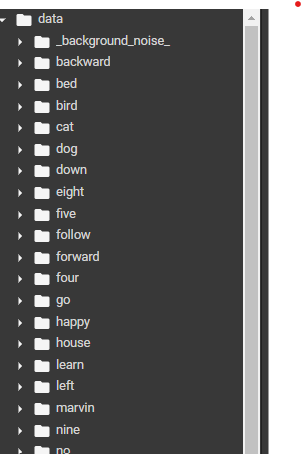

In [ ]:
import os
import pathlib
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import wave
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
#Dateipfad aller Daten im Verzeichnis "data"
DATASET_PATH = 'data'
#Dateipfad der für das ML-Model Training ausgewählten Daten
AUDIO_SUBFOLDER = 'audio'
#Füge Audio-Ordner in dem Data-Ordner ein
DATASET_AUDIO_PATH = os.path.join(DATASET_PATH, AUDIO_SUBFOLDER)

data_dir = pathlib.Path(DATASET_PATH)
#Lade Daten herunter, wenn sie nicht bereits heruntergeladen sind 
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

### 1.1 Move die Folder mit den relevanten Datensatzen in den "audio"-folder

DATASET_AUDIO_PATH gibt den Datenpfad zu dem directory an 

In [ ]:
#Erstelle Audio-Ordner, wenn er noch nicht vorhanden ist
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)
#Iteriere über heruntergeladene Ordner, "folder" enthält den Ordnernamen 
for folder in os.listdir(data_dir):
  if os.path.isdir(os.path.join(DATASET_PATH, folder)):
    #Filter Bedingung: nur die Ordner "dog", "cat", "bird" etc werden fürs Training verwendet
    if folder == "dog" or folder == "cat" or folder == "bird" or folder == "house" or folder == "bed":

      if folder in AUDIO_SUBFOLDER:
        continue
      else:
        #wenn folder noch nicht in Audio-Ordner ist, füge ihn ein
        shutil.move(
            os.path.join(DATASET_PATH, folder),
            os.path.join(DATASET_AUDIO_PATH, folder),
        )
        print(folder) #wird irgendwie nix geprinted

#Directory der herausgesuchten Audiodaten
data_audio_dir = pathlib.Path(DATASET_AUDIO_PATH)

cat
bed
bird
house
dog


###  1.2 Extrahiere zu klassifizierende Wörter

Die Audioclips des Datensatzes werden in 36 Ordnern gespeichert, die jedem Sprachbefehl "bed", "bird, "cat", "dog" etc entsprechen

(Screenshot zeigt exemplarisch alle möglichen commands des dataset)

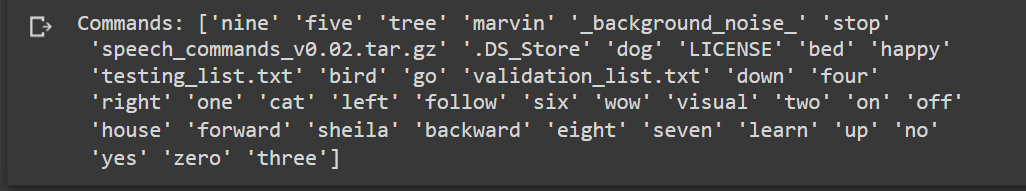

In [ ]:
#Gebe die Wörter aus die gelern werden können
commands = np.array(tf.io.gfile.listdir(str(data_audio_dir))) 
print("All Commands: ", commands)

All Commands:  ['cat' 'bed' 'bird' 'house' 'dog']


### Display all .wav files from first command 

In [ ]:
#Gebe alle Dateien aus dem Audio-Ordner aus
print(str(data_audio_dir/commands[0]))
tf.io.gfile.listdir(str(data_audio_dir/commands[0]))z

## 1.3 Extrahiere Audioclips in eine Liste namens "filenames" und mische sie  


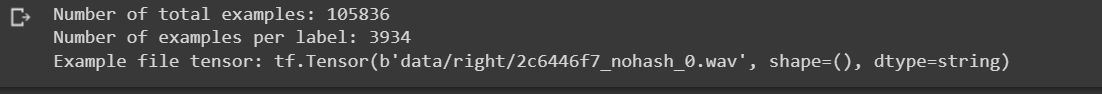

In [ ]:
filenames = tf.io.gfile.glob(str(data_audio_dir) + '/*/*')
print(filenames[0])

data/audio/bed/84d1e469_nohash_1.wav


In [ ]:
filenames = tf.random.shuffle(filenames) # Umwandlung von Strings in EagerTensor

num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_audio_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 10350
Number of examples per label: 2031
Example file tensor: tf.Tensor(b'data/audio/bird/00f0204f_nohash_3.wav', shape=(), dtype=string)


In [ ]:
# test_files ist eine List von EagerTensor zu Audiodateien z.B. b'data/audio/cat/bd76a7fd_nohash_0.wav'

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:] # Type test_files[0]:  <class 'tensorflow.python.framework.ops.EagerTensor'>
print("test_files: ", type(test_files[0]))
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

test_files:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
print(filenames[0])

tf.Tensor(b'data/audio/bird/00f0204f_nohash_3.wav', shape=(), dtype=string)


### 1.4 Hilfsfunktionen: Decodiere .wav-Datei zu Tensoren & beschrifte die Dateien mit den jeweiligen Ordnernamen als Labels

In [ ]:
test_file = tf.io.read_file(DATASET_AUDIO_PATH+'/bed/4beff0c5_nohash_1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
print("test_audio: ", type(test_audio))
test_audio.shape

test_audio:  <class 'tensorflow.python.framework.ops.EagerTensor'>


TensorShape([10923, 1])

 *decode_audio()*:  Funktion, die die rohen WAV-Audiodateien in Audiotensoren vorverarbeitet

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

*get_label():* Funktion die Labeles unter Verwendung der übergeordneten Verzeichnisse für jede Datei erstellt

In [ ]:
def get_label(file_path):
  print("file_path: ", file_path)
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

*get_waveform_and_label()*: Funktion, die alles zusammenfasst: Eingabe ist der WAV-Audiodateiname; Ausgabe ist ein Tupel, das die Audio- & Label Tensoren enthält, die fürs supervised Learning bereit sind

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print("label",label)
  audio_binary = tf.io.read_file(file_path)
  print("audio_binary", audio_binary)
  waveform = decode_audio(audio_binary)
  print("waveform", waveform)
  return waveform, label

# Ab hier hab ich keine Ahnung mehr lol

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)


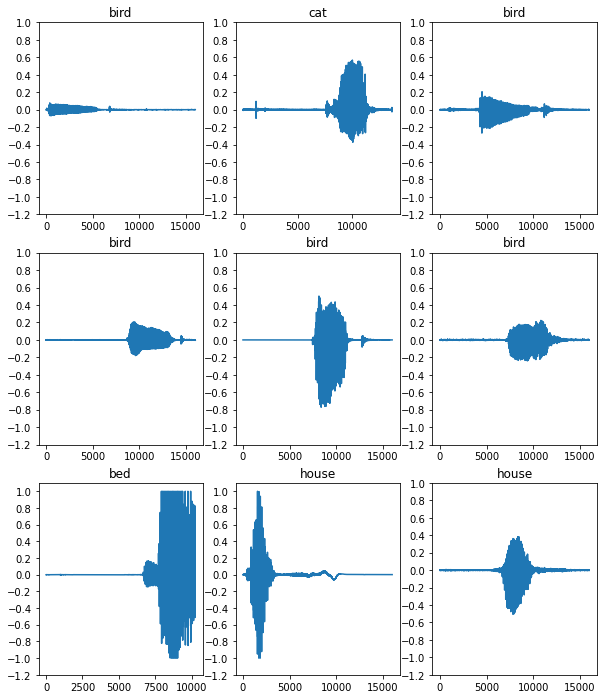

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

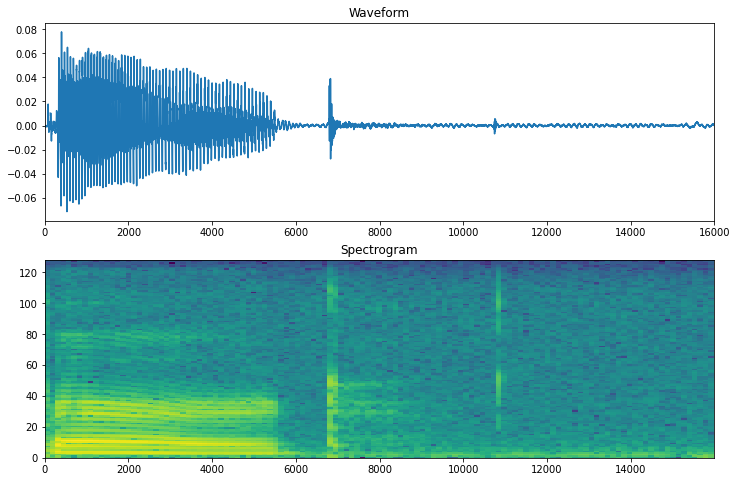

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

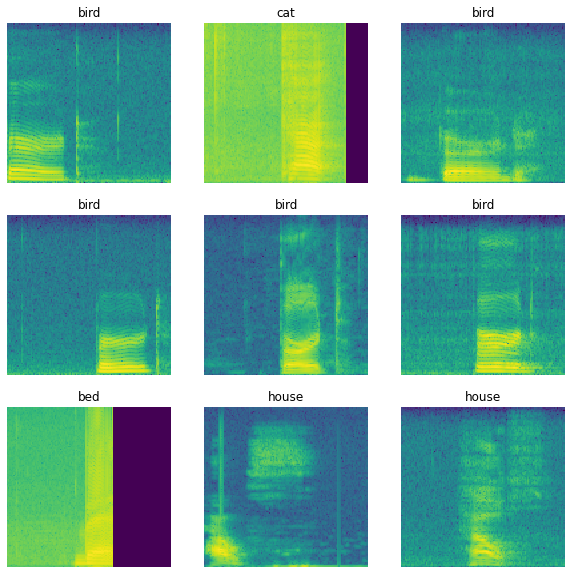

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Preprocessing | Erstelle & Trainiere das Modell

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files) # List von EagerTensor wird Preprocessed

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)


In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
  print(input_shape)

(124, 129, 1)


In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print("num_labels",num_labels)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),# evtl. sigmoid nehmen
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (124, 129, 1)
num_labels 5
INFO:tensorflow:Assets written to: /audio_hello/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                           

In [ ]:
# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [ ]:
model.save('/hello_world/model1.h5')
from tensorflow import keras
my_saved_model = keras.models.load_model("/hello_world/model1.h5")
#weights_path = '/weights_folder/'
#model.save_weights(weights_path)

In [ ]:
# Train model
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
100/100 [==============================] - 93s 915ms/step - loss: 1.0234 - accuracy: 0.6345 - val_loss: 0.6958 - val_accuracy: 0.7613
Epoch 2/20
100/100 [==============================] - 50s 497ms/step - loss: 0.6097 - accuracy: 0.7937 - val_loss: 0.4957 - val_accuracy: 0.8413
Epoch 3/20
100/100 [==============================] - 39s 384ms/step - loss: 0.4668 - accuracy: 0.8388 - val_loss: 0.4385 - val_accuracy: 0.8575
Epoch 4/20
100/100 [==============================] - 35s 353ms/step - loss: 0.3841 - accuracy: 0.8702 - val_loss: 0.3862 - val_accuracy: 0.8750
Epoch 5/20
100/100 [==============================] - 34s 343ms/step - loss: 0.3426 - accuracy: 0.8850 - val_loss: 0.3491 - val_accuracy: 0.8938
Epoch 6/20
100/100 [==============================] - 32s 324ms/step - loss: 0.2899 - accuracy: 0.9047 - val_loss: 0.3628 - val_accuracy: 0.8863
Epoch 7/20
100/100 [==============================] - 36s 357ms/step - loss: 0.2504 - accuracy: 0.9137 - val_loss: 0.4444 - val_ac

In [ ]:
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-save-and-load-a-model-with-keras.md
from tensorflow.keras.models import Sequential, save_model
filepath = './saved_model1234'
# Save the model as "saved_model"
save_model(model, filepath)
#or save model in .h5-Format
#save_model(model, filepath, save_format='h5')

INFO:tensorflow:Assets written to: ./saved_model1234/assets


In [ ]:
#load model
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np
# Load the model
# Load the model
loaded_model = load_model(
    filepath,
    custom_objects=None,
    compile=True
)

sample_file = "/content/data/go/004ae714_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])

print(sample_ds)

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


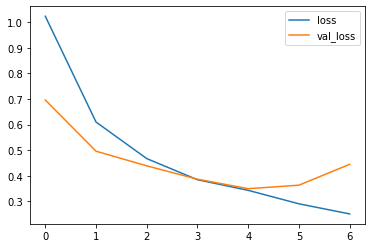

In [ ]:
# Unterschied zw loss & val_loss
#https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
"""
 audio type <class 'tensorflow.python.framework.ops.EagerTensor'>
 audio.numpy()
 [[1.1779948e-03]
  [2.3660650e-03]
  [3.9937301e-03]
  ...
  [1.3035707e-05]
  [7.4541813e-06]
  [1.1023192e-05]]


test_audionp.array():  [[[[5.00388327e-04]
   [5.24558267e-03]
   [1.66959874e-02]
   ...
   [1.64770216e-04]
   [6.34707612e-05]
   [4.65429621e-05]]
   """

"\n audio type <class 'tensorflow.python.framework.ops.EagerTensor'>\n audio.numpy()\n [[1.1779948e-03]\n  [2.3660650e-03]\n  [3.9937301e-03]\n  ...\n  [1.3035707e-05]\n  [7.4541813e-06]\n  [1.1023192e-05]]\n\n\ntest_audionp.array():  [[[[5.00388327e-04]\n   [5.24558267e-03]\n   [1.66959874e-02]\n   ...\n   [1.64770216e-04]\n   [6.34707612e-05]\n   [4.65429621e-05]]\n   "

In [ ]:
# Test Datensatz von TensorFlow Docu
test_audio = []
test_labels = []
#test_ds = preprocess_dataset(test_files) # List von EagerTensor wird Preprocessed

for audio, label in test_ds:

  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio) #test_audio:  <class 'numpy.ndarray'>
print("test_audio: ", type(test_audio[0]))
test_labels = np.array(test_labels)

test_audio:  <class 'numpy.ndarray'>


In [ ]:
#type sample_ds:  <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
#filenames[0] "data/audio/bird/e9b61425_nohash_0.wav"


# test_audio, _ = tf.audio.decode_wav(contents=test_file)

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  print("output_ds1: ",output_ds)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  print("output_ds2: ",output_ds)
  return output_ds

In [ ]:
# ---------------- Einzel Audio File ---------------- 
# Go
#file_path = "/content/data/audio/bed/00176480_nohash_0.wav"
# Bed
#file_path = "/content/data/audio/bed/00176480_nohash_0.wav"
#Backwards
file_path = "/content/data/backward/017c4098_nohash_0.wav"
#Stille
#file_path = "/content/1punkt5stille.wav"
# 1. Deklariere Liste für  Audio Datein
audio_file_list = [] 
# 2. Füge Dateipfad als String zur Liste hinzu # go 
audio_file_list.append(str(file_path))

# 3. Konvertiere Liste zu EagerTensor
audio_file_list = tf.random.shuffle(audio_file_list) 
#print("audio_file_list: ", type(audio_file_list[0]))
wavefile = audio_file_list[0]
print("wavefile: ", audio_file_list[0])

#display.display(display.Audio(file_path, rate=16000))

#x = get_waveform_and_label(str(file_path))

# 4. Übergebe Liste von EagerTensoren an Preprocessing Funktion & speichere Ergebnis in einer neuen liste
audio_ds = preprocess_dataset(audio_file_list) # Preprocessen Liste von EagerTensoren
print("audio_ds preprocessing: ", audio_ds)
# 5. Füge Preprocesste Audiodateien als num
list_audio = [] # type sample_ds:  <class 'numpy.ndarray'>
for audio, label  in audio_ds:
  print("audio", audio)
  list_audio.append(audio.numpy())

#print("list_audio", list_audio[0])

# 6. Wandle liste in NumpyArray um
list_audio = np.array(list_audio) #list_audio <class 'numpy.ndarray'>
#print("list_audio", type(list_audio[0]))


wavefile:  tf.Tensor(b'/content/data/backward/017c4098_nohash_0.wav', shape=(), dtype=string)
file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
output_ds1:  <ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
output_ds2:  <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
audio_ds preprocessing:  <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
audio tf.Tensor(
[[[1.7316279e-03]
  [1.3886853e-02]
  [2.1415662e-02]
  ...
  [6.3834706e-04]
  [2.6962798e-04]
  [1.7632789e-05]]

 [[3.7865725e-03]
  [1.8838823e-02]
  [2.0115480e-02]
  ...

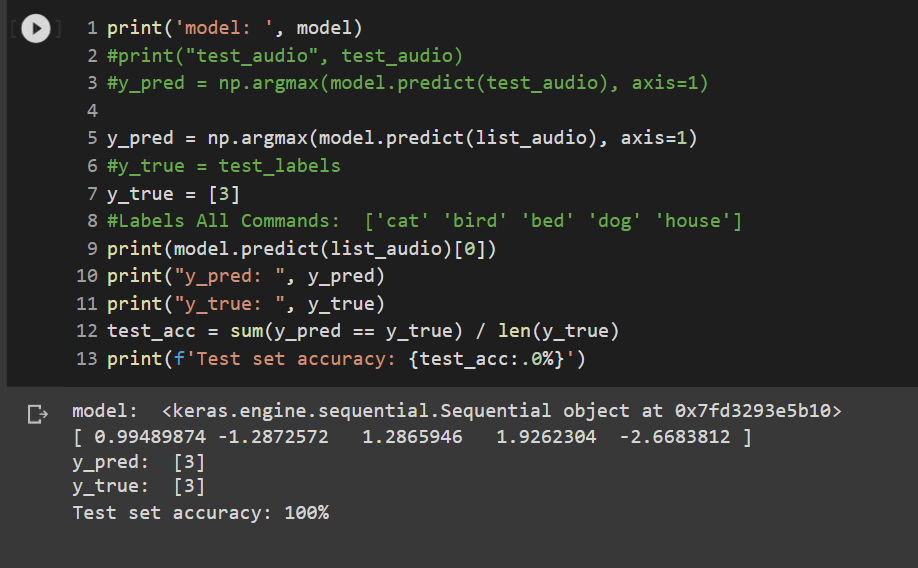

In [ ]:
print('model: ', model)
#print("test_audio", test_audio)
y_pred = np.argmax(my_saved_model.predict(test_audio), axis=1)

y_pred = np.argmax(my_saved_model.predict(list_audio), axis=1)
#y_true = [0,1,2,3,4] ## macht keinen Sinn welche Labels müssen hier reingegeben werden?
#y_pred = np.argmax(model.predict(test_labels)[0])
#y_pred = np.argmax(model.predict(test_labels), axis = 1)
#Labels All Commands:  ['cat' 'bird' 'bed' 'dog' 'house']
# Todo ergebnis 
print("predict: ", model.predict(list_audio)[0])
result =  model.predict(list_audio)[0]
#Sigmoid funktion 



model:  <keras.engine.sequential.Sequential object at 0x7fb597484350>
predict:  [ 4.2140994 -2.8171515  0.6773671 -4.9202332  1.1555715]


In [ ]:
# Sigmpoid Funktion 

import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid_list = []
# Bringe alle prediction Werte auf eine Scala
for prediction in result:
  calc = sigmoid(prediction)
  sigmoid_list.append(calc)
print("sigmoid_list: ", sigmoid_list)

# Display highest pred value & index to get label from 'commands' list 
index = 0
value = 0
zw_index = 0
for prediction in sigmoid_list:
  zw_index +=1
  print("prediction", prediction)
  if value < prediction:
    value = prediction
    index = zw_index
    print("index: ", index)
print("commands: ", commands)

if(value < 0.1):
  print("word konnte nicht erkannt werden, spreche das richtige label")
else: 
  print("value: ", value, "label: ", commands[index-1], "index: ", index)
#print("y_pred: ", y_pred)
#print("y_true: ", y_true)
#test_acc = sum(y_pred == y_true) / len(y_true)
#print(f'Test set accuracy: {test_acc:.0%}')

sigmoid_list:  [0.9854297980324785, 0.05640434509556222, 0.6631508063295692, 0.007244561853187223, 0.7605270951292906]
prediction 0.9854297980324785
index:  1
prediction 0.05640434509556222
prediction 0.6631508063295692
prediction 0.007244561853187223
prediction 0.7605270951292906
commands:  ['cat' 'bed' 'bird' 'house' 'dog']
value:  0.9854297980324785 label:  cat index:  1


# Die Konfusionsmatrix zeigt für die jeweiligen Labels an wie gut sie erkannt wurden (?)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: ignored

In [ ]:
#sample_file = data_audio_dir/'pred_dog.wav'
sample_file = "/content/data/go/004ae714_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])
print(sample_ds)

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


label: tf.Tensor([0], shape=(1,), dtype=int64)
tf.Tensor([0], shape=(1,), dtype=int64)
prediction tf.Tensor([ 0.86412406 -0.8177709  -3.2487254  -3.7076886   2.7759914 ], shape=(5,), dtype=float32)


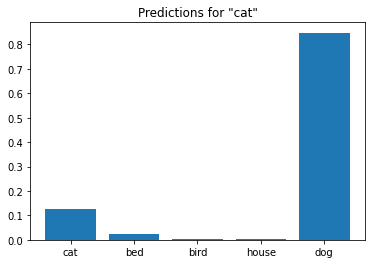

In [ ]:
for spectrogram, label in sample_ds.batch(1):
  print("label:", label)
  print(label)
  prediction = model(spectrogram)
  print("prediction",prediction[0])
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
import keras

!mkdir -p saved_model
model.save('tensorflow_speakq/audio_classification')
#model_audio =  tf.saved_model.load("/content/tensorflow_speakq/audio_classification/")
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

INFO:tensorflow:Assets written to: tensorflow_speakq/audio_classification/assets
Saved model to disk


# Voice recorder

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),# evtl. sigmoid nehmen
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.load_weights('model.json')

In [ ]:
model.save_weights("model.json")

In [ ]:
file_path = "/content/data/backward/017c4098_nohash_0.wav"

#########

#Hier muss binäre Datei wieder in wav umgewandelt werden

##########
# 1. Deklariere Liste für  Audio Datein
audio_file_list = [] 

# 2. Füge Dateipfad als String zur Liste hinzu # go 
audio_file_list.append(str(file_path))

# 3. Konvertiere Liste zu EagerTensor
audio_file_list = tf.random.shuffle(audio_file_list) 

wavefile = audio_file_list[0] 

# 4. Übergebe Liste von EagerTensoren an Preprocessing Funktion & speichere Ergebnis in einer neuen liste
audio_ds = preprocess_dataset(audio_file_list) # Preprocessen Liste von EagerTensoren

# 5. Füge Preprocesste Audiodateien als num
list_audio = [] # type sample_ds:  <class 'numpy.ndarray'>
for audio, label  in audio_ds:
  list_audio.append(audio.numpy())

# 6. Wandle liste in NumpyArray um
list_audio = np.array(list_audio) #list_audio <class 'numpy.ndarray'>

y_pred = np.argmax(model.predict(test_audio), axis=1)

y_pred = np.argmax(model.predict(list_audio), axis=1)

# Todo ergebnis 
print("predict: ", model.predict(list_audio)[0])
result =  model.predict(list_audio)[0]


file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
predict:  [  8.946716    -4.9298053   -2.1762464  -10.709395     0.23121068]


In [ ]:
# Sigmpoid Funktion 

import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid_list = []
# Bringe alle prediction Werte auf eine Scala
for prediction in result:
  calc = sigmoid(prediction)
  sigmoid_list.append(calc)
print("sigmoid_list: ", sigmoid_list)

# Display highest pred value & index to get label from 'commands' list 
index = 0
value = 0
zw_index = 0
for prediction in sigmoid_list:
  zw_index +=1
  print("prediction", prediction)
  if value < prediction:
    value = prediction
    index = zw_index
    print("index: ", index)
print("commands: ", commands)

if(value < 0.1):
  print("word konnte nicht erkannt werden, spreche das richtige label")
else: 
  print("value: ", value, "label: ", commands[index-1], "index: ", index)


sigmoid_list:  [0.9998698530633664, 0.007176042776487034, 0.10190394220935105, 2.2333612161145747e-05, 0.5575465357867188]
prediction 0.9998698530633664
index:  1
prediction 0.007176042776487034
prediction 0.10190394220935105
prediction 2.2333612161145747e-05
prediction 0.5575465357867188
commands:  ['cat' 'bed' 'bird' 'house' 'dog']
value:  0.9998698530633664 label:  cat index:  1
